Importing libraries

In [1]:
from preprocess import load_all_data, preprocess_coffee_data, build_features
from evaluation import get_user_relevance, ndcg_at_k
from recommender import recommend, recommend_popular
import lightgbm as lgb
import numpy as np
import pandas as pd
import joblib
import os

Data loading

In [2]:
# Load all datasets required for training and validation
recipes_raw, users_raw, train_raw, val_warm_raw, val_cold_raw = load_all_data()

Preprocessing and feature engineering

In [3]:
# Transform raw data and generate the interaction matrix
recipes, users, train = preprocess_coffee_data(recipes_raw, users_raw, train_raw)
train_matrix = build_features(train, recipes, users)

Feature selection

In [4]:
# Select relevant numerical features for the ranking model
numeric_features = [
    'taste_bitterness', 'taste_sweetness', 'taste_acidity', 'taste_body', 'strength_norm',
    'taste_pref_bitterness', 'taste_pref_sweetness', 'taste_pref_acidity', 'taste_pref_body', 'pref_strength_norm',
    'delta_bitterness', 'delta_sweetness', 'delta_acidity', 'delta_body', 'strength_match'
]

X_train = train_matrix[numeric_features]
y_train = train_matrix['final_score']

Model training

In [5]:
model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2513
[LightGBM] [Info] Number of data points in the train set: 75895, number of used features: 15
[LightGBM] [Info] Start training from score 3.070044


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Model serialization

In [6]:
if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(model, 'models/coffee_model.pkl')
print("Model successfully saved to models/coffee_model.pkl")

Model successfully saved to models/coffee_model.pkl


Performance Evaluation (NDCG@5)

In [7]:
# Evaluate model performance against the popularity baseline using NDCG@5
test_users = val_warm_raw['user_id'].unique()[:50]
scores_pop = []
scores_ml = []

for u_id in test_users:
    # Baseline: Popularity-based recommendations
    pop_recs = recommend_popular(u_id, users, recipes, train)
    rel_pop = get_user_relevance(u_id, [r[0] for r in pop_recs], val_warm_raw)
    scores_pop.append(ndcg_at_k(rel_pop))
    
    # Proposed: Hybrid ML-based recommendations
    ml_recs = recommend(u_id, users, recipes, train)
    rel_ml = get_user_relevance(u_id, [r[0] for r in ml_recs], val_warm_raw)
    scores_ml.append(ndcg_at_k(rel_ml))

print(f"\nEvaluation Results (Mean NDCG@5):")
print(f"Popularity Baseline: {np.mean(scores_pop):.4f}")
print(f"Hybrid ML Model:     {np.mean(scores_ml):.4f}")


Evaluation Results (Mean NDCG@5):
Popularity Baseline: 0.5875
Hybrid ML Model:     0.6831


Result visualization

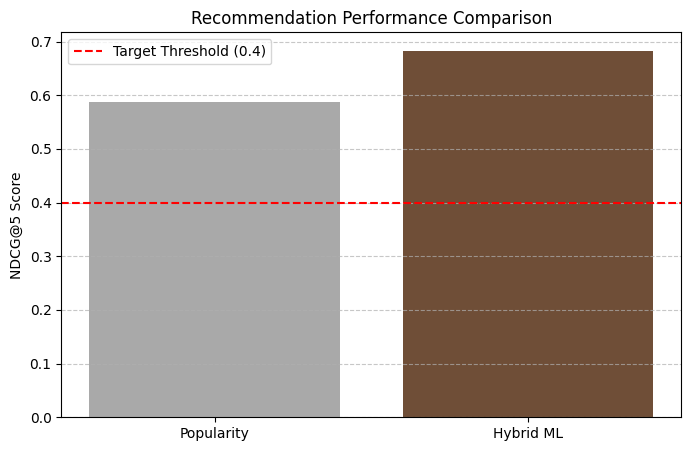

In [8]:
import matplotlib.pyplot as plt

# Visualize performance comparison for the pitch presentation
methods = ['Popularity', 'Hybrid ML']
values = [np.mean(scores_pop), np.mean(scores_ml)]

plt.figure(figsize=(8, 5))
plt.bar(methods, values, color=['#A9A9A9', '#6F4E37'])
plt.ylabel('NDCG@5 Score')
plt.title('Recommendation Performance Comparison')
plt.axhline(y=0.4, color='red', linestyle='--', label='Target Threshold (0.4)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()